In [ ]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF

import matplotlib.pyplot as plt
import numpy as np

# Pattern Recognition nel tempo

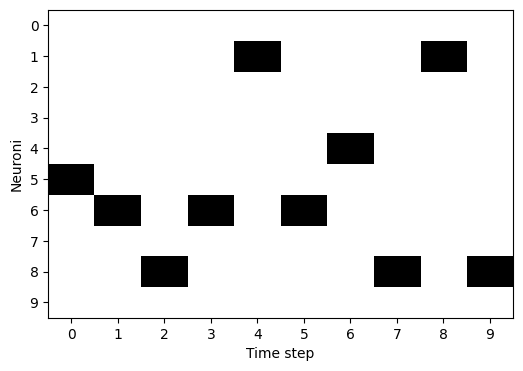

In [ ]:
# Impostazioni della Simulazione e dei Dati

num_inputs = 10
num_hidden = 64
num_outputs = 1
num_steps = 100
batch_size = 64
num_epochs = 100
learning_rate = 0.005
dtype = torch.float

def generate_target_pattern(num_steps=10, num_inputs=10, seed=None):

    torch.manual_seed(seed)
    np.random.seed(seed)

    pattern = torch.zeros(num_steps, num_inputs)

    for t in range(num_steps):
        rand_idx = np.random.randint(0, num_inputs)
        pattern[t, rand_idx] = 1.0
    return pattern

target_pattern = generate_target_pattern(num_steps=10, num_inputs=10, seed=9)
pattern_len = len(target_pattern)
pattern_width = len(target_pattern[0])

def generate_data(batch_size, num_steps, noise_prob=0.05):
    # Rumore iniziale
    spike_data = (torch.rand(batch_size, num_steps, num_inputs) < noise_prob).float()
    targets = torch.zeros(batch_size, num_steps, num_outputs)

    for i in range(batch_size):
        start_idx = np.random.randint(0, num_steps - pattern_len)

        # Inseriamo il pattern
        spike_data[i, start_idx:start_idx + pattern_len, :pattern_width] = target_pattern

        # Inseriamo target subito dopo il pattern
        target_time = start_idx + pattern_len
        if target_time < num_steps:
            targets[i, target_time, 0] = 1.0

    return spike_data, targets


plt.figure(figsize=(6, 4))
plt.imshow(target_pattern.T, aspect='auto', cmap="Greys", interpolation="nearest")
plt.xlabel("Time step")
plt.ylabel("Neuroni")
plt.xticks(np.arange(10));
plt.yticks(np.arange(10));

In [ ]:
# Definizione del Modello SNN

class Model(nn.Module):
    def __init__(self,num_inputs,num_hidden,num_outputs,num_steps=25,beta=0.95):
        super().__init__()

        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_steps = num_steps
        self.num_outputs = num_outputs
        self.beta = beta

        self.fc1 = nn.Linear(self.num_inputs,self.num_hidden)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(self.num_hidden, self.num_outputs)
        self.lif2 = snn.Leaky(beta=self.beta)

    def forward(self, x):

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

model = Model(num_inputs,num_hidden, num_outputs, num_steps)

In [ ]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Inizio addestramento con neuroni Leaky e MSELoss...")
for epoch in range(num_epochs):
    spk_in, targets = generate_data(batch_size, num_steps)
    spk_out, mem_out = model(spk_in)

    loss_val = torch.zeros((1), dtype=dtype, device=device)
    for step in range(num_steps):
        loss_val += loss_fn(mem_out[step], targets)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoca {epoch}/{num_epochs} - Loss: {loss_val.item():.4f}")
print("Addestramento completato.\n")


Inizio addestramento con neuroni Leaky e MSELoss...
Epoca 0/100 - Loss: 489.6456
Epoca 10/100 - Loss: 35.5641
Epoca 20/100 - Loss: 27.6152
Epoca 30/100 - Loss: 9.8108
Epoca 40/100 - Loss: 5.6177
Epoca 50/100 - Loss: 3.4283
Epoca 60/100 - Loss: 3.0862
Epoca 70/100 - Loss: 2.6471
Epoca 80/100 - Loss: 2.4847
Epoca 90/100 - Loss: 2.3351
Addestramento completato.



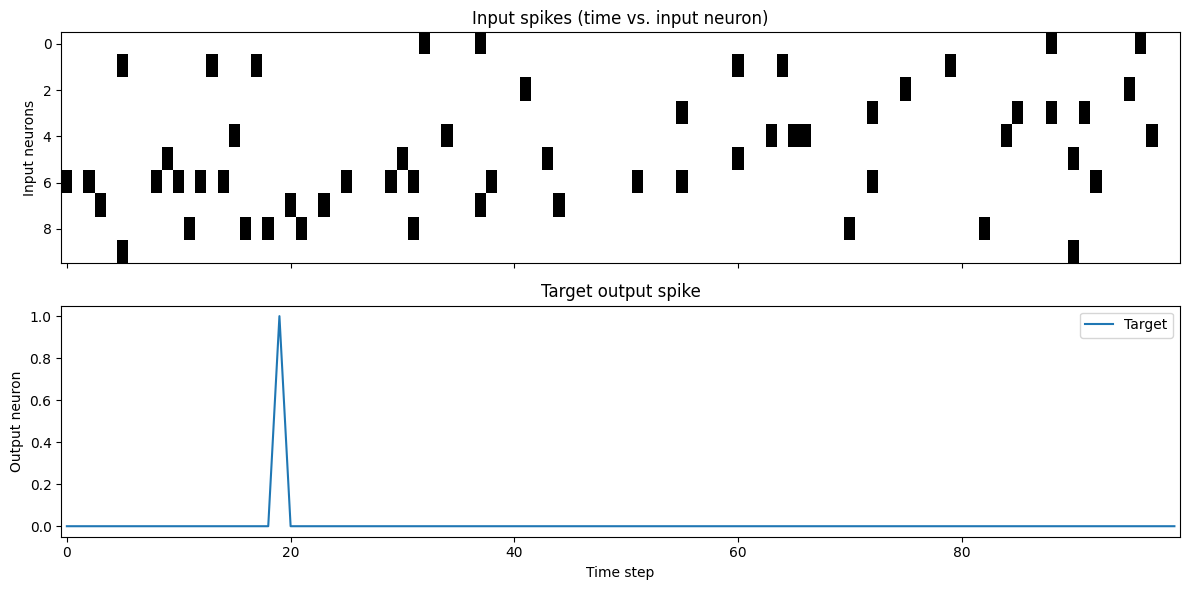

In [ ]:
# ---- Funzione di plotting ----
def plot_sequence(spike_data, targets, sample_idx=0):

    seq_in = spike_data[sample_idx].cpu().numpy()   # [num_steps, num_inputs]
    seq_tg = targets[sample_idx].cpu().numpy()      # [num_steps, num_outputs]

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # --- Input spikes (raster) ---
    axes[0].imshow(seq_in.T, aspect="auto", cmap="Greys", interpolation="nearest")
    axes[0].set_title("Input spikes (time vs. input neuron)")
    axes[0].set_ylabel("Input neurons")

    # --- Target output ---
    axes[1].plot(seq_tg, label="Target")
    axes[1].set_title("Target output spike")
    axes[1].set_xlabel("Time step")
    axes[1].set_ylabel("Output neuron")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


# ---- Esempio di utilizzo ----
# Genera un batch di dati di test
spk_in, targets = generate_data(batch_size=4, num_steps=num_steps)

# Plot di una sequenza del batch
plot_sequence(spk_in, targets, sample_idx=0)


In [ ]:
def test_model(model, num_steps=50, batch_size=1, sample_idx=0):
    """
    Testa il modello su una sequenza generata e mostra input, target e output.
    """
    model.eval()  # modalità test (no dropout, no batchnorm update)

    # Genero dati di test
    spk_in, targets = generate_data(batch_size, num_steps)

    # Forward pass
    with torch.no_grad():
        spk_out, mem_out = model(spk_in)

    # Converto in numpy per plotting
    seq_in = spk_in[sample_idx].cpu().numpy()        # [num_steps, num_inputs]
    seq_tg = targets[sample_idx].cpu().numpy()       # [num_steps, num_outputs]
    seq_out = mem_out[:, sample_idx, 0].cpu().numpy()  # [num_steps]

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Input spikes (raster)
    axes[0].imshow(seq_in.T, aspect="auto", cmap="Greys", interpolation="nearest")
    # axes[0].set_xticks(np.arange(10))
    axes[0].set_yticks(np.arange(10))
    axes[0].set_title("Input spikes (time × input neuron)")
    axes[0].set_ylabel("Input neurons")

    # Target
    axes[1].plot(seq_tg, label="Target", color="red")
    axes[1].set_title("Target output spike")
    axes[1].set_ylabel("Output neuron")
    axes[1].legend()

    # # Output del modello
    # axes[2].plot(seq_out, label="Membrane potential (output)", color="blue")
    # axes[2].set_title("Rete: attività neurone di output")
    # axes[2].set_xlabel("Time step")
    # axes[2].set_ylabel("V_mem")
    # axes[2].legend()

    plt.tight_layout()
    plt.show()

    return spk_in, targets, spk_out, mem_out


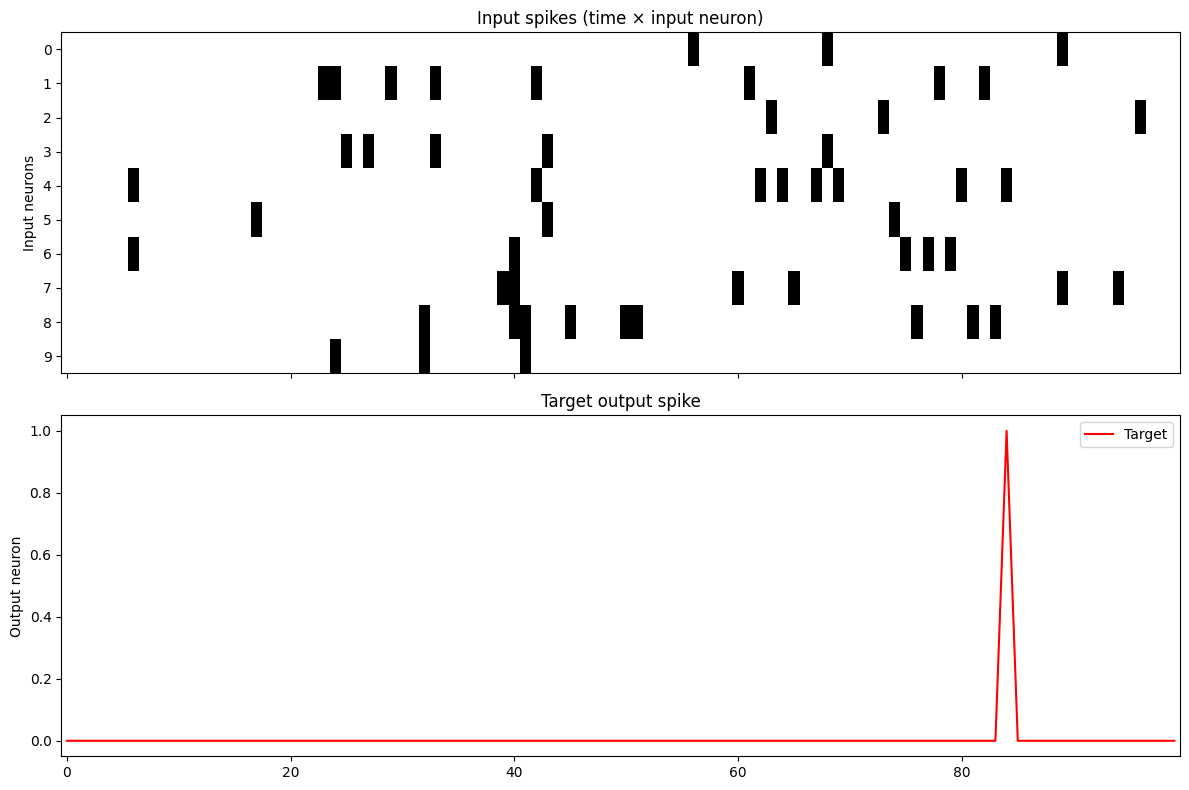

In [ ]:
pattern_len = len(target_pattern)
pattern_width = len(target_pattern[0])



# Esegui test con una sequenza
spk_in, targets, spk_out, mem_out = test_model(model, num_steps=100, batch_size=1)

# Nota:
# - num_steps=50 → lunghezza della sequenza di test
# - batch_size=1 → una sola sequenza, più facile da plottare